In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# ---------------------- 2. Load Preprocessed Data ----------------------
# These are already cleaned and split in R
train_data = pd.read_csv("C:/Users/tasne/OneDrive/Desktop/UoB/M7_Interdisciplinary Health Data Research Project/Final Binary/train_data_final.csv")
test_data  = pd.read_csv("C:/Users/tasne/OneDrive/Desktop/UoB/M7_Interdisciplinary Health Data Research Project/Final Binary/test_data_final.csv")

# ---------------------- Convert Target to Binary (Cleaned) ----------------------
train_data['heartoa'] = train_data['heartoa'].str.strip().map({'no_OA': 0, 'OA': 1})
test_data['heartoa'] = test_data['heartoa'].str.strip().map({'no_OA': 0, 'OA': 1})
# ---------------------- Optional: Define Variable Groups (For Later Use) ----------------------
continuous_vars = ['age', 'grip_mean']
binary_vars = [
    "hepawkn", "hepawba", "hepawhi", "hepawfe", "hepawot",
    "hemobch", "hemobcs", "hemobcl", "hemobpi", "hemobpu",
    "hemobwa", "hemobre", "hemobsi", "hemobst", "headlba",
    "headlbe", "headldr", "mmpain", "sex"
]
ordinal_vars = ["hehelf", "hepaa"]

# ---------------------- Check Structure of Imported Data ----------------------
print(" Train data structure:")
print(train_data.info())

print("\n Test data structure:")
print(test_data.info())

print("\n Train Target Distribution:")
print(train_data['heartoa'].value_counts(dropna=False))

print("\n Test Target Distribution:")
print(test_data['heartoa'].value_counts(dropna=False))

 Train data structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3779 entries, 0 to 3778
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hepaa      3779 non-null   int64  
 1   hemobst    3779 non-null   int64  
 2   hepawkn    3779 non-null   int64  
 3   hepawba    3779 non-null   int64  
 4   hemobch    3779 non-null   int64  
 5   hepawhi    3779 non-null   int64  
 6   hemobcs    3779 non-null   int64  
 7   hehelf     3779 non-null   int64  
 8   grip_mean  3779 non-null   float64
 9   hepawfe    3779 non-null   int64  
 10  hemobpu    3779 non-null   int64  
 11  hemobsi    3779 non-null   int64  
 12  hemobcl    3779 non-null   int64  
 13  headldr    3779 non-null   int64  
 14  hemobwa    3779 non-null   int64  
 15  hepawot    3779 non-null   int64  
 16  hemobre    3779 non-null   int64  
 17  sex        3779 non-null   int64  
 18  mmpain     3779 non-null   int64  
 19  headlbe    3779 non-null 

# CatBoost Model

### CV

In [5]:
# ---------------------- 1. Import Required Libraries ----------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

# ---------------------- 3. Define Features & Target ----------------------
X_train_cb = train_data.drop(columns='heartoa')
y_train_cb = train_data['heartoa']

X_test_cb = test_data.drop(columns='heartoa')
y_test_cb = test_data['heartoa']

# ---------------------- 4. Initialize CatBoost Model ----------------------
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=3,
    eval_metric='Logloss',
    loss_function='Logloss',
    random_seed=123,
    verbose=0
)

# ---------------------- 5. Cross-Validated Train Probabilities ----------------------
cv_cb = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_train_proba_cv_cb = cross_val_predict(
    cat_model, X_train_cb, y_train_cb, cv=cv_cb, method="predict_proba"
)[:, 1]
train_auc_cb = roc_auc_score(y_train_cb, y_train_proba_cv_cb)

# ---------------------- 6. Apply Custom Threshold ----------------------
threshold_cb = 0.4
y_train_pred_cv_cb = (y_train_proba_cv_cb >= threshold_cb).astype(int)

# ---------------------- 7. Fit Final CatBoost Model ----------------------
cat_model.fit(X_train_cb, y_train_cb)

# ---------------------- 8. Predict on Test Set ----------------------
y_test_proba_cb = cat_model.predict_proba(X_test_cb)[:, 1]
y_test_pred_cb = (y_test_proba_cb >= threshold_cb).astype(int)
test_auc_cb = roc_auc_score(y_test_cb, y_test_proba_cb)

# ---------------------- 9. Evaluate Test Set Only ----------------------
def evaluate_test_only(y_true, y_pred, y_proba, auc_train, auc_test, threshold, dataset_name="Test"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0
    f1_no_OA = 2 * (npv * specificity) / (npv + specificity) if (npv + specificity) > 0 else 0

    print(f"\n {dataset_name} Evaluation @ Threshold {threshold}")
    print(f" Accuracy        : {acc:.3f}")
    print(f" AUC (Train CV)  : {auc_train:.3f}")
    print(f" AUC (Test Set)  : {auc_test:.3f}")

    print("\n Confusion Matrix:")
    print(cm)

    print("\n Per-Class Evaluation:")

    print("\nClass: OA (Positive Class)")
    print(f"  Precision            : {prec:.3f}")
    print(f"  Recall (Sensitivity) : {rec:.3f}")
    print(f"  F1 Score             : {f1:.3f}")

    print("\nClass: no_OA (Negative Class)")
    print(f"  NPV (Precision)       : {npv:.3f}")
    print(f"  Specificity (Recall)  : {specificity:.3f}")
    print(f"  F1 Score              : {f1_no_OA:.3f}")

# ---------------------- 10. Final Test Evaluation ----------------------
evaluate_test_only(
    y_test_cb, y_test_pred_cb, y_test_proba_cb,
    auc_train=train_auc_cb,
    auc_test=test_auc_cb,
    threshold=threshold_cb,
    dataset_name="Test"
)


 Test Evaluation @ Threshold 0.4
 Accuracy        : 0.714
 AUC (Train CV)  : 0.743
 AUC (Test Set)  : 0.757

 Confusion Matrix:
[[482 128]
 [142 192]]

 Per-Class Evaluation:

Class: OA (Positive Class)
  Precision            : 0.600
  Recall (Sensitivity) : 0.575
  F1 Score             : 0.587

Class: no_OA (Negative Class)
  NPV (Precision)       : 0.772
  Specificity (Recall)  : 0.790
  F1 Score              : 0.781


### Upsampling

In [7]:
# ---------------------- 1. Import Required Libraries ----------------------
from imblearn.over_sampling import RandomOverSampler
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import pandas as pd

# ---------------------- 2. Define Features & Target ----------------------
X_train_cb_up = train_data.drop(columns='heartoa')
y_train_cb_up = train_data['heartoa']

X_test_cb_up = test_data.drop(columns='heartoa')
y_test_cb_up = test_data['heartoa']

# ---------------------- 3. Upsample the Training Set ----------------------
ros = RandomOverSampler(random_state=42)
X_train_cb_up_res, y_train_cb_up_res = ros.fit_resample(X_train_cb_up, y_train_cb_up)

# ---------------------- 4. Initialize CatBoost Model ----------------------
cat_model_cb_up = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=4,
    eval_metric='Logloss',
    loss_function='Logloss',
    random_seed=123,
    verbose=0
)

# ---------------------- 5. Cross-Validated AUC on Training Set ----------------------
cv_cb_up = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_train_proba_cv_cb_up = cross_val_predict(
    cat_model_cb_up, X_train_cb_up_res, y_train_cb_up_res,
    cv=cv_cb_up, method="predict_proba"
)[:, 1]
train_auc_cb_up = roc_auc_score(y_train_cb_up_res, y_train_proba_cv_cb_up)

# ---------------------- 6. Train Final Model ----------------------
cat_model_cb_up.fit(X_train_cb_up_res, y_train_cb_up_res)

# ---------------------- 7. Predict on Test Set ----------------------
threshold_cb_up = 0.5
y_test_proba_cb_up = cat_model_cb_up.predict_proba(X_test_cb_up)[:, 1]
y_test_pred_cb_up = (y_test_proba_cb_up >= threshold_cb_up).astype(int)
test_auc_cb_up = roc_auc_score(y_test_cb_up, y_test_proba_cb_up)

# ---------------------- 8. Bootstrap AUC CI ----------------------
from sklearn.utils import resample

def bootstrap_auc_ci(y_true, y_score, n_bootstraps=1000, ci=0.95):
    rng = np.random.RandomState(42)
    bootstrapped_scores = []
    y_true = np.array(y_true)
    y_score = np.array(y_score)

    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_score), len(y_score))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_score[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.sort(bootstrapped_scores)
    lower = sorted_scores[int((1.0 - ci) / 2 * len(sorted_scores))]
    upper = sorted_scores[int((1.0 + ci) / 2 * len(sorted_scores))]
    return round(lower, 3), round(upper, 3)

# ---------------------- 9. Evaluation Function with CI ----------------------
def evaluate_test_only_with_ci(y_true, y_pred, y_proba, auc_train, auc_test, threshold, dataset_name="Test", alpha=0.05):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0
    f1_no_OA = 2 * (npv * specificity) / (npv + specificity) if (npv + specificity) > 0 else 0

    # Wilson confidence intervals
    def ci_wilson(success, total):
        lower, upper = proportion_confint(count=success, nobs=total, alpha=alpha, method='wilson')
        return round(lower, 3), round(upper, 3)

    ci_acc  = ci_wilson(TP + TN, len(y_true))
    ci_rec  = ci_wilson(TP, TP + FN)
    ci_spec = ci_wilson(TN, TN + FP)
    ci_prec = ci_wilson(TP, TP + FP)
    ci_npv  = ci_wilson(TN, TN + FN)
    ci_auc_test = bootstrap_auc_ci(y_true, y_proba)

    # Output
    print(f"\n {dataset_name} Evaluation @ Threshold {threshold}")
    print(f" Accuracy        : {acc:.3f} (95% CI: {ci_acc[0]}–{ci_acc[1]})")
    print(f" AUC (Train CV)  : {auc_train:.3f}")
    print(f" AUC (Test Set)  : {auc_test:.3f} (95% CI: {ci_auc_test[0]}–{ci_auc_test[1]})")

    print("\n Confusion Matrix:")
    print(cm)

    print("\n Per-Class Evaluation:")

    print("\nClass: OA (Positive Class)")
    print(f"  Precision            : {prec:.3f} (95% CI: {ci_prec[0]}–{ci_prec[1]})")
    print(f"  Recall (Sensitivity) : {rec:.3f} (95% CI: {ci_rec[0]}–{ci_rec[1]})")
    print(f"  F1 Score             : {f1:.3f}")

    print("\nClass: no_OA (Negative Class)")
    print(f"  NPV (Precision)       : {npv:.3f} (95% CI: {ci_npv[0]}–{ci_npv[1]})")
    print(f"  Specificity (Recall)  : {specificity:.3f} (95% CI: {ci_spec[0]}–{ci_spec[1]})")
    print(f"  F1 Score              : {f1_no_OA:.3f}")

# ---------------------- 10. Final Test Evaluation with CI ----------------------
evaluate_test_only_with_ci(
    y_test_cb_up, y_test_pred_cb_up, y_test_proba_cb_up,
    auc_train=train_auc_cb_up,
    auc_test=test_auc_cb_up,
    threshold=threshold_cb_up,
    dataset_name="Test"
)


 Test Evaluation @ Threshold 0.5
 Accuracy        : 0.703 (95% CI: 0.673–0.732)
 AUC (Train CV)  : 0.782
 AUC (Test Set)  : 0.747 (95% CI: 0.714–0.78)

 Confusion Matrix:
[[463 147]
 [133 201]]

 Per-Class Evaluation:

Class: OA (Positive Class)
  Precision            : 0.578 (95% CI: 0.525–0.628)
  Recall (Sensitivity) : 0.602 (95% CI: 0.548–0.653)
  F1 Score             : 0.589

Class: no_OA (Negative Class)
  NPV (Precision)       : 0.777 (95% CI: 0.742–0.808)
  Specificity (Recall)  : 0.759 (95% CI: 0.724–0.791)
  F1 Score              : 0.768


### Downsampling

In [9]:
# ---------------------- 1. Import Required Libraries ----------------------
from imblearn.under_sampling import RandomUnderSampler
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---------------------- 3. Define Features & Target ----------------------
X_train_cb_down = train_data.drop(columns='heartoa')
y_train_cb_down = train_data['heartoa']

X_test_cb_down = test_data.drop(columns='heartoa')
y_test_cb_down = test_data['heartoa']

# ---------------------- 4. Downsample Training Set ----------------------
rus = RandomUnderSampler(random_state=42)
X_train_cb_down_res, y_train_cb_down_res = rus.fit_resample(X_train_cb_down, y_train_cb_down)

# ---------------------- 5. Initialize CatBoost Model ----------------------
cat_model_cb_down = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=4,
    eval_metric='Logloss',
    loss_function='Logloss',
    random_seed=123,
    verbose=0
)

# ---------------------- 6. Cross-Validated Probabilities & AUC on Training ----------------------
cv_cb_down = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_train_proba_cv_cb_down = cross_val_predict(
    cat_model_cb_down, X_train_cb_down_res, y_train_cb_down_res, cv=cv_cb_down, method="predict_proba"
)[:, 1]
train_auc_cb_down = roc_auc_score(y_train_cb_down_res, y_train_proba_cv_cb_down)

# ---------------------- 7. Classification Threshold ----------------------
threshold_cb_down = 0.55
y_train_pred_cv_cb_down = (y_train_proba_cv_cb_down >= threshold_cb_down).astype(int)

# ---------------------- 8. Fit Final Model on Full Downsampled Training Set ----------------------
cat_model_cb_down.fit(X_train_cb_down_res, y_train_cb_down_res)

# ---------------------- 9. Predict on Untouched Test Set ----------------------
y_test_proba_cb_down = cat_model_cb_down.predict_proba(X_test_cb_down)[:, 1]
y_test_pred_cb_down = (y_test_proba_cb_down >= threshold_cb_down).astype(int)
test_auc_cb_down = roc_auc_score(y_test_cb_down, y_test_proba_cb_down)

# ---------------------- 10. Evaluate Test Set Only ----------------------
def evaluate_test_only(y_true, y_pred, y_proba, auc_train, auc_test, threshold, dataset_name="Test"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0
    f1_no_OA = 2 * (npv * specificity) / (npv + specificity) if (npv + specificity) > 0 else 0

    print(f"\n {dataset_name} Evaluation @ Threshold {threshold}")
    print(f" Accuracy        : {acc:.3f}")
    print(f" AUC (Train CV)  : {auc_train:.3f}")
    print(f" AUC (Test Set)  : {auc_test:.3f}")

    print("\n Confusion Matrix:")
    print(cm)

    print("\n Per-Class Evaluation:")

    print("\nClass: OA (Positive Class)")
    print(f"  Precision            : {prec:.3f}")
    print(f"  Recall (Sensitivity) : {rec:.3f}")
    print(f"  F1 Score             : {f1:.3f}")

    print("\nClass: no_OA (Negative Class)")
    print(f"  NPV (Precision)       : {npv:.3f}")
    print(f"  Specificity (Recall)  : {specificity:.3f}")
    print(f"  F1 Score              : {f1_no_OA:.3f}")

# ---------------------- 11. Final Test Evaluation ----------------------
evaluate_test_only(
    y_test_cb_down, y_test_pred_cb_down, y_test_proba_cb_down,
    auc_train=train_auc_cb_down,
    auc_test=test_auc_cb_down,
    threshold=threshold_cb_down,
    dataset_name="Test"
)


 Test Evaluation @ Threshold 0.55
 Accuracy        : 0.710
 AUC (Train CV)  : 0.732
 AUC (Test Set)  : 0.751

 Confusion Matrix:
[[479 131]
 [143 191]]

 Per-Class Evaluation:

Class: OA (Positive Class)
  Precision            : 0.593
  Recall (Sensitivity) : 0.572
  F1 Score             : 0.582

Class: no_OA (Negative Class)
  NPV (Precision)       : 0.770
  Specificity (Recall)  : 0.785
  F1 Score              : 0.778


### Plotting AUC 

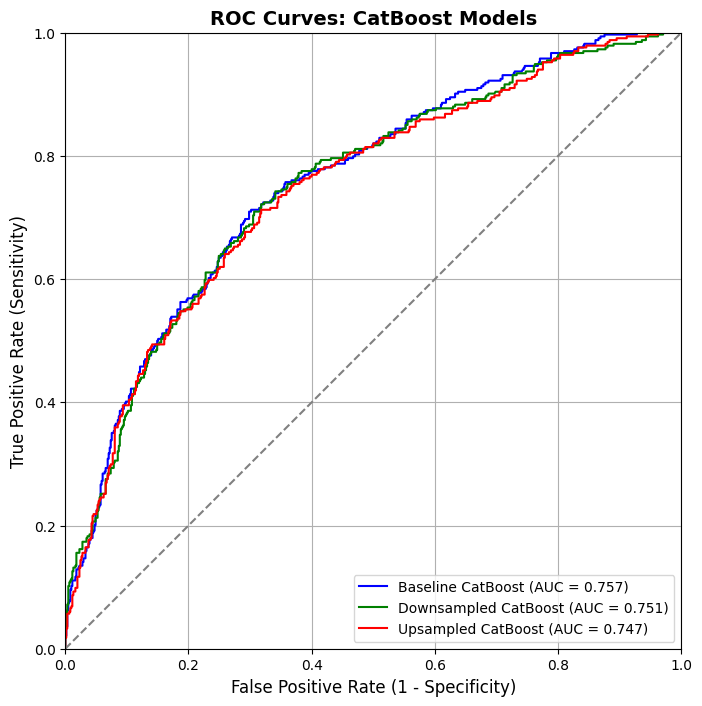

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# --- Compute ROC and AUC for Each Model ---
roc_data_cb = []

# Baseline
fpr_cb_base, tpr_cb_base, _ = roc_curve(y_test_cb, y_test_proba_cb)
auc_cb_base = auc(fpr_cb_base, tpr_cb_base)
roc_data_cb.append({
    "label": "Baseline CatBoost",
    "fpr": fpr_cb_base,
    "tpr": tpr_cb_base,
    "auc": auc_cb_base,
    "color": "blue"
})

# Upsampled
fpr_cb_up, tpr_cb_up, _ = roc_curve(y_test_cb_up, y_test_proba_cb_up)
auc_cb_up = auc(fpr_cb_up, tpr_cb_up)
roc_data_cb.append({
    "label": "Upsampled CatBoost",
    "fpr": fpr_cb_up,
    "tpr": tpr_cb_up,
    "auc": auc_cb_up,
    "color": "red"
})

# Downsampled
fpr_cb_down, tpr_cb_down, _ = roc_curve(y_test_cb_down, y_test_proba_cb_down)
auc_cb_down = auc(fpr_cb_down, tpr_cb_down)
roc_data_cb.append({
    "label": "Downsampled CatBoost",
    "fpr": fpr_cb_down,
    "tpr": tpr_cb_down,
    "auc": auc_cb_down,
    "color": "green"
})

# --- Sort Models by AUC Descending ---
roc_data_cb_sorted = sorted(roc_data_cb, key=lambda x: x["auc"], reverse=True)

# --- Plot ROC Curves ---
plt.figure(figsize=(8, 8))

for model in roc_data_cb_sorted:
    plt.plot(
        model["fpr"], model["tpr"],
        label=f"{model['label']} (AUC = {model['auc']:.3f})",
        color=model["color"]
    )

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate (1 - Specificity)", fontsize=12)
plt.ylabel("True Positive Rate (Sensitivity)", fontsize=12)
plt.title("ROC Curves: CatBoost Models", fontsize=14, fontweight="bold")
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

# --- Save Plot ---
plt.savefig(
    "C:/Users/tasne/OneDrive/Desktop/UoB/M7_Interdisciplinary Health Data Research Project/Final Binary/catboost_roc_curves_sorted.png",
    dpi=300, bbox_inches='tight', facecolor='white'
)
plt.show()

In [12]:
from sklearn.metrics import roc_curve, auc
import pandas as pd

# --- Compute ROC for CatBoost Downsampled ---
fpr_cb_up, tpr_cb_up, _ = roc_curve(y_test_cb_up, y_test_proba_cb_up)
auc_cb_up = auc(fpr_cb_up, tpr_cb_up)

# --- Create DataFrame ---
roc_cb_up_df = pd.DataFrame({
    "FPR": fpr_cb_up,
    "TPR": tpr_cb_up,
    "Model": [f"CatBoost (Upsampled) - AUC: {auc_cb_up:.3f}"] * len(fpr_cb_up)
})

# --- Export to CSV ---
roc_cb_up_df.to_csv(
    "C:/Users/tasne/OneDrive/Desktop/UoB/M7_Interdisciplinary Health Data Research Project/Final Binary/roc_cb_upsampled.csv",
    index=False
)